In [21]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [23]:
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [24]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 4
    IMG_HEIGHT:  int = 256
    IMG_WIDTH:   int = 256
    CHANNELS:    int = 3
        
    DATA_ROOT_TRAIN:  str = r"C:\Users\PC\Documents\Dataset_VGGNET16\train"
    DATA_ROOT_TEST:  str = r"C:\Users\PC\Documents\Dataset_VGGNET16\test"
    DATA_ROOT_VALIDACION: str = r"C:\Users\PC\Documents\Dataset_VGGNET16\validacion"


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 20
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8    

In [25]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=32,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH)
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALIDACION,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH)
                                            )

test_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TEST,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH)
                                            )

Found 1264 files belonging to 4 classes.
Found 633 files belonging to 4 classes.
Found 540 files belonging to 4 classes.


In [26]:
print(train_dataset.class_names)

['0', '1', '2', '3']


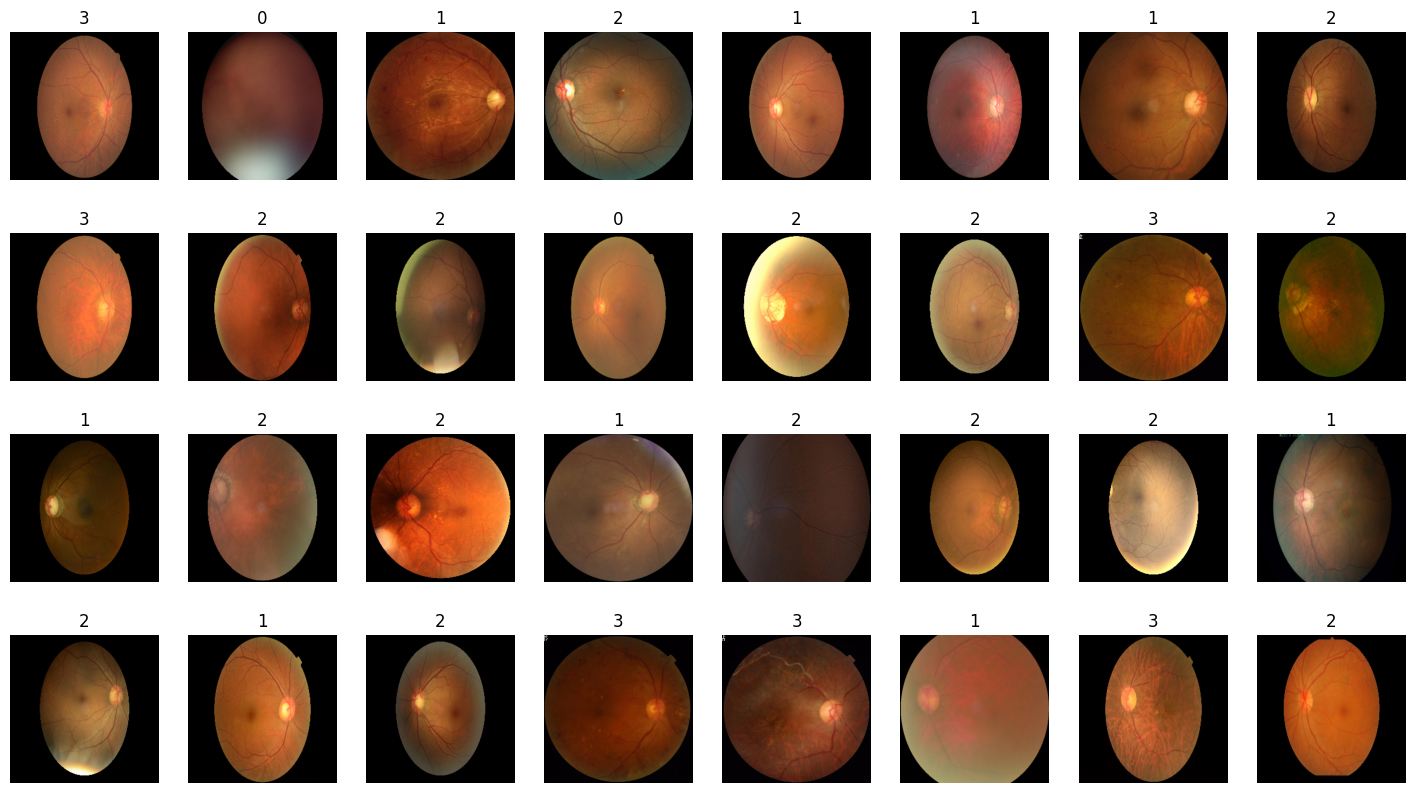

In [27]:
class_names = train_dataset.class_names

plt.figure(figsize=(18,10))

num_rows = 4
num_cols = 8

for image_batch, labels_batch in train_dataset.take(1): 
     
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [28]:
class_names_int = list(map(int, train_dataset.class_names))
gtid_2_cnidx = dict(zip(class_names_int, range(0,DatasetConfig.NUM_CLASSES)))
gtid_2_cnidx.items()

dict_items([(0, 0), (1, 1), (2, 2), (3, 3)])

In [29]:
print('Train/Valid dataset class names: ',train_dataset.class_names)

Train/Valid dataset class names:  ['0', '1', '2', '3']


In [30]:
input_shape = (256, 256, 3)

vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, 
                                                    weights='imagenet',
                                                   )
print(vgg16_conv_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [31]:
vgg16_conv_base.trainable = True

num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

for model_layer in vgg16_conv_base.layers[:num_layers - num_layers_fine_tune]:
    print(f"Congelando capa: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Se entrenan las ultimas", num_layers_fine_tune, "capas")
print("\n")
    
print(vgg16_conv_base.summary())

Congelando capa: <keras.engine.input_layer.InputLayer object at 0x00000220D0D70F70>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x00000220D0D5DE80>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x00000220D0D4E400>
Congelando capa: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000220D0D81130>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x00000220D0D7EDC0>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x00000220D0D8CDC0>
Congelando capa: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000220D0D972E0>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x00000220D0D97DC0>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x00000220D0D8C5E0>
Congelando capa: <keras.layers.convolutional.conv2d.Conv2D object at 0x00000220D0DA16D0>
Congelando capa: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000220D0DA57F0>


Se 

In [32]:
inputs = tf.keras.Input(shape=input_shape)
    
x = tf.keras.applications.vgg16.preprocess_input(inputs)
    
x = vgg16_conv_base(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)
    
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
    
model_vgg16_finetune = keras.Model(inputs, outputs)

print(model_vgg16_finetune.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194

In [33]:
model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )

In [34]:
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=TrainingConfig.EPOCHS,
                                            validation_data=valid_dataset,
                                           )

Epoch 1/20
40/40 [==============================] - 286s 7s/step - loss: 1.9639 - accuracy: 0.4960 - val_loss: 0.8851 - val_accuracy: 0.6414
Epoch 2/20
40/40 [==============================] - 283s 7s/step - loss: 0.9826 - accuracy: 0.5989 - val_loss: 0.8257 - val_accuracy: 0.6967
Epoch 3/20
40/40 [==============================] - 288s 7s/step - loss: 0.8797 - accuracy: 0.6448 - val_loss: 0.8423 - val_accuracy: 0.7062
Epoch 4/20
40/40 [==============================] - 296s 7s/step - loss: 0.8350 - accuracy: 0.6606 - val_loss: 0.7707 - val_accuracy: 0.7330
Epoch 5/20
40/40 [==============================] - 311s 8s/step - loss: 0.7405 - accuracy: 0.7128 - val_loss: 0.6676 - val_accuracy: 0.7488
Epoch 6/20
40/40 [==============================] - 321s 7s/step - loss: 0.7246 - accuracy: 0.7231 - val_loss: 0.6953 - val_accuracy: 0.7346
Epoch 7/20
40/40 [==============================] - 282s 7s/step - loss: 0.7311 - accuracy: 0.7128 - val_loss: 0.7103 - val_accuracy: 0.7520
Epoch 8/20
40

In [35]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

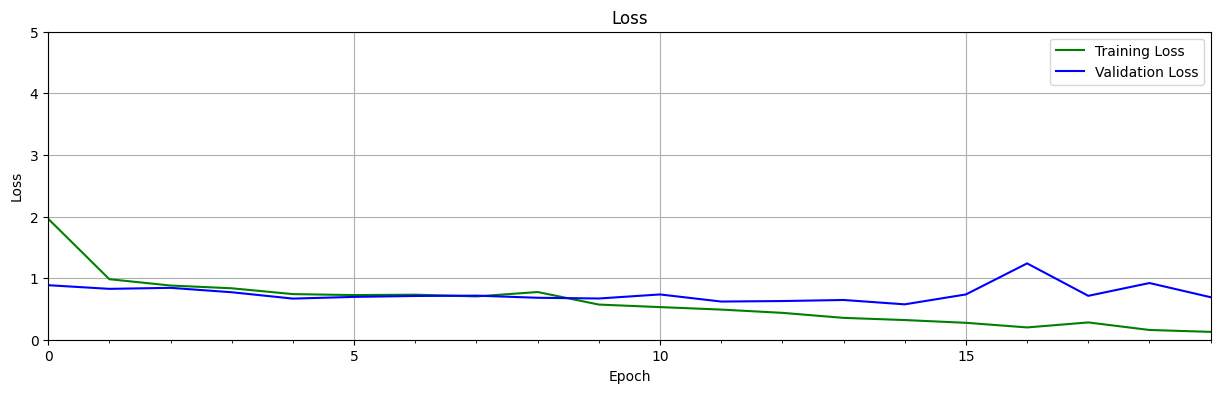

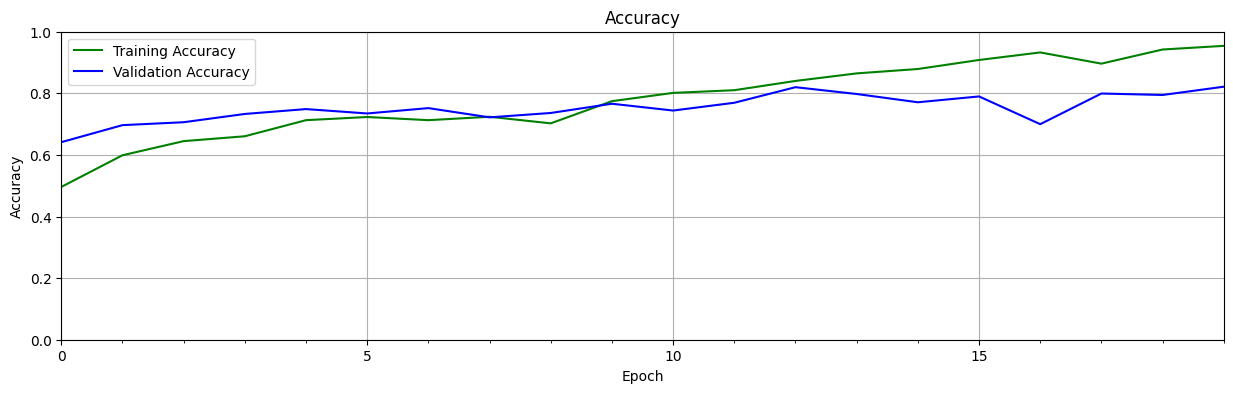

In [36]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [37]:
print(f"Test accuracy: {model_vgg16_finetune.evaluate(test_dataset)[1]*100.:.3f}")

17/17 [==============================] - 51s 3s/step - loss: 1.0348 - accuracy: 0.7704
Test accuracy: 77.037


In [38]:
def display_predictions(dataset, model, class_names):
    
    plt.figure(figsize=(20,20))
    num_rows = 8
    num_cols = 8
    jdx = 0
    
    for image_batch, labels_batch in dataset.take(2):
        
        print(image_batch.shape)
        
        predictions = model.predict(image_batch)
        
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()
            
            if pred_idx == truth_idx:
                color='g'
            else:
                color='r'
                
            jdx += 1
                
            if jdx > num_rows*num_cols:
                break
                
            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])
                
            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"));
    return 

(32, 256, 256, 3)
1/1 [==============================] - 3s 3s/step
(32, 256, 256, 3)
1/1 [==============================] - 3s 3s/step


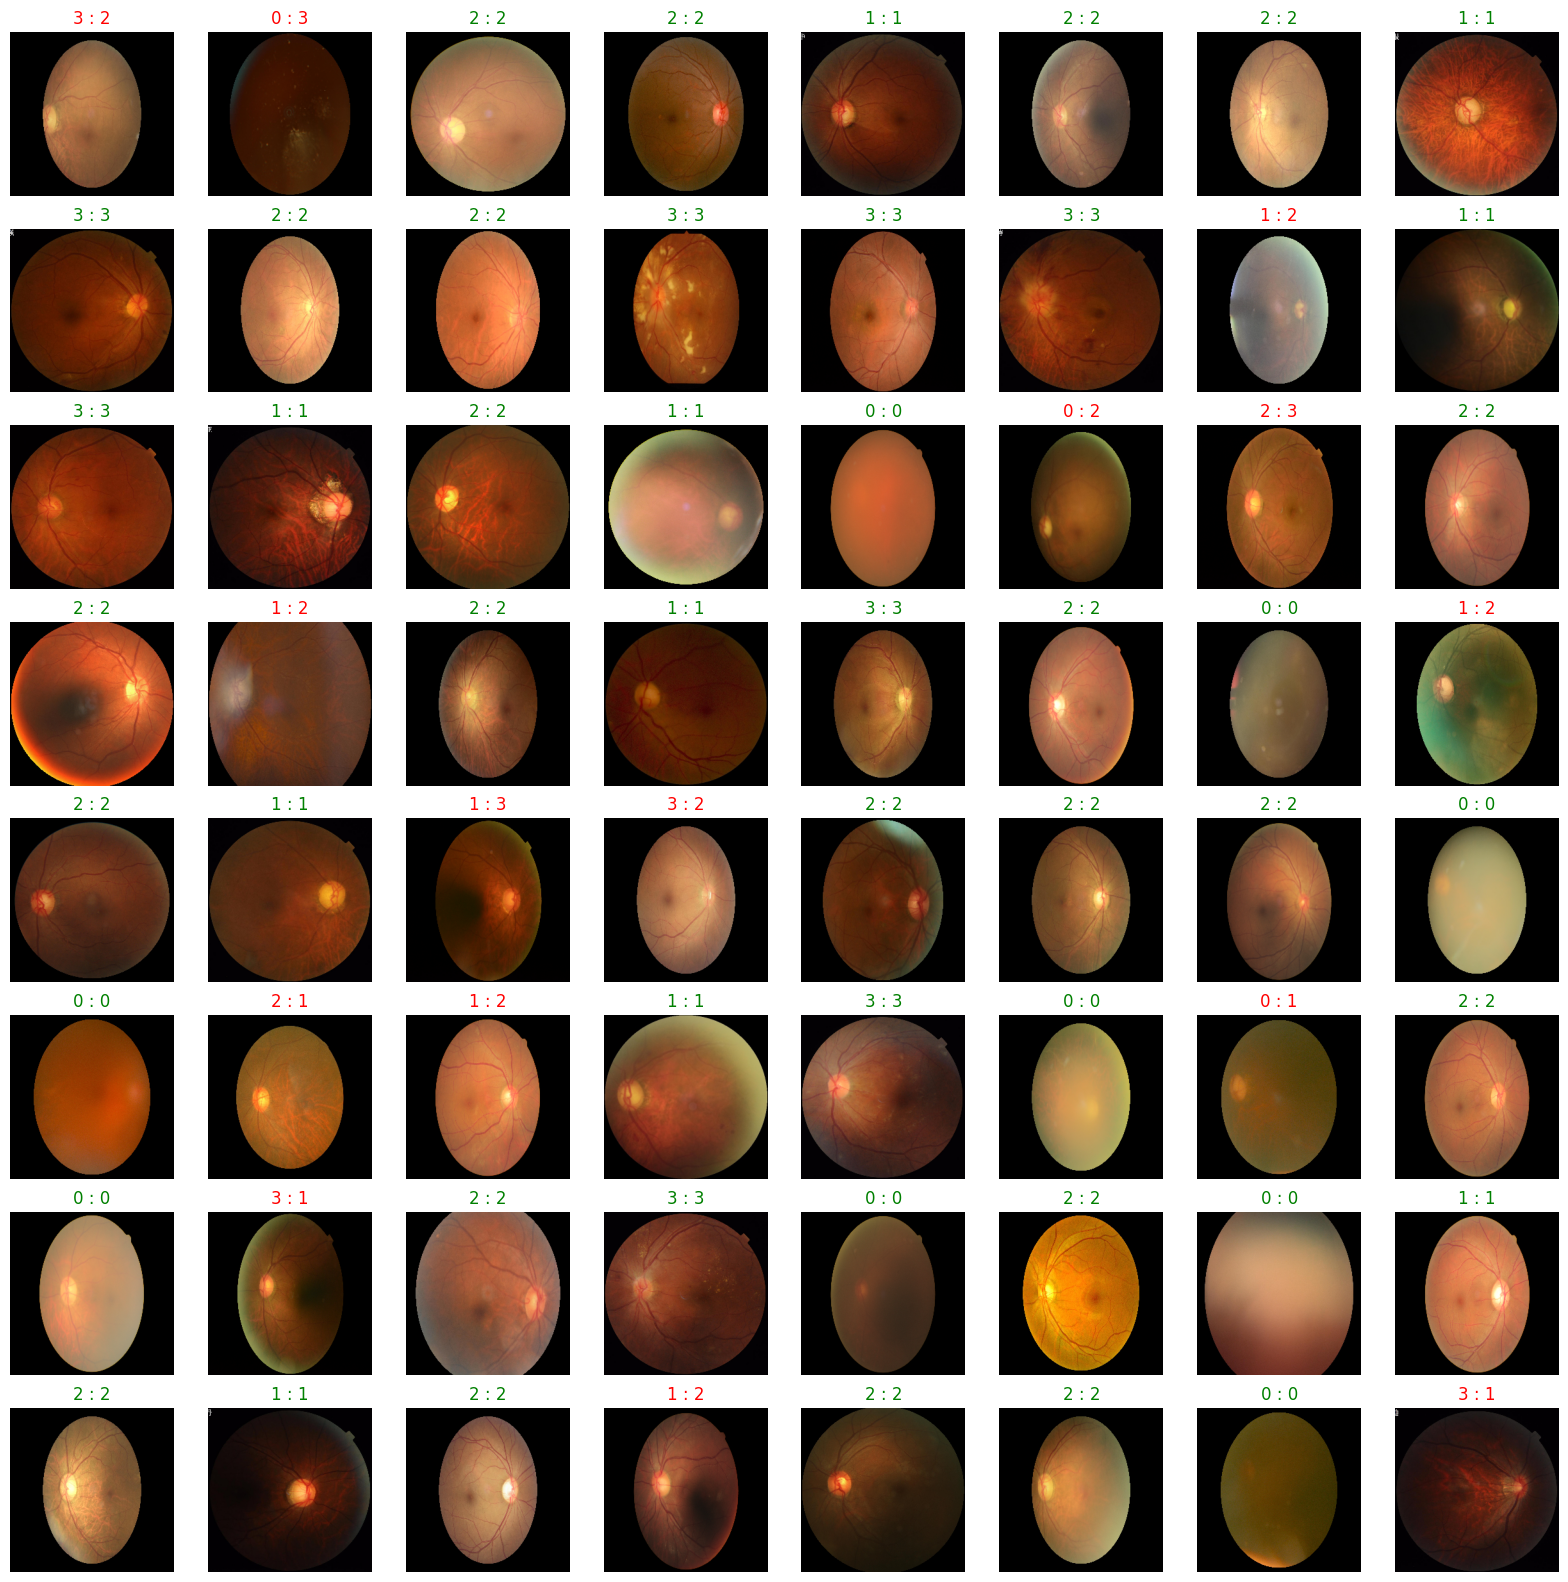

In [39]:
display_predictions(test_dataset, model_vgg16_finetune, class_names)